## Defining the problem - clearly identifying the problem to be solved
Boston Housing - Regression problem


## Data Collection - gathering necessary data from various sources

Importing the necessary libraries and defining the functions

In [373]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [374]:
# functions required
# calculate test r-squared
def calculate_test_r2(y_pred, y_test):
    return r2_score(y_test, y_pred)

def get_test_size():
    return 0.2

def get_random_state():
    return 0

def get_k_fold_cv(k, random_state, X, y):
  kfold = KFold(n_splits = k, shuffle = True, random_state = random_state)
  spl = kfold.split(X)
  return spl

# forward selection to select features
def forward_selection(X_train, y_train, X_test, y_test):
  selected_features = []
  selected_features_list = []
  r2_test_list = []
  all_features = list(X_train.columns)
  remaining_features = list(X_train.columns)
  print(f"All Features: {all_features}")
  p = X.shape[1]
  m0 = np.mean(y)
  result = []
  for k in range(p):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    best_feature = None
    best_model = None
    print(f"K = {k}")
    for feature in remaining_features:
      print(f"current feature: {feature}")
      temp_features.append(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      print(f"Best R-Squared and R-Squared-train after adding current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        best_feature = feature
        best_model = model
      temp_features.remove(feature)
      print(f"Current best feature: {best_feature}")
    selected_features.append(best_feature)
    print(f"Selected features: {selected_features}")
    remaining_features.remove(best_feature)
    print(f"Remaining features: {remaining_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)
    result_k = [best_model, r2_test]
    result.append(result_k)
  return result


def mixed_selection(X_train, y_train, X_test, y_test):
  selected_features = []
  selected_features_list = []
  r2_test_list = []
  all_features = list(X_train.columns)
  remaining_features = list(X_train.columns)
  print(f"All Features: {all_features}")
  p = X.shape[1]
  m0 = np.mean(y)
  result = []
  for k in range(p):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    best_feature = None
    best_model = None
    print(f"K = {k}")
    for feature in remaining_features:
      print(f"current feature: {feature}")
      temp_features.append(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      print(f"Best R-Squared and R-Squared-train after adding current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        best_feature = feature
        best_model = model
      temp_features.remove(feature)
      print(f"Current best feature: {best_feature}")
    selected_features.append(best_feature)
    print(f"Selected features: {selected_features}")
    remaining_features.remove(best_feature)
    print(f"Remaining features: {remaining_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)

    if k > 1:
      current_selected_features = selected_features.copy()
      best_r2_test_subset = float('-inf')
      temp_features1 = current_selected_features
      removed_features = []
      selected_features_length = len(selected_features)
      for k1 in range(selected_features_length):
        print(f"Selected features length: {len(selected_features)}")
        print(f"Value of K1: {k1}")
        print(f"Best model features: {best_model.model.exog_names}")
        removed_feature = selected_features[k1]
        print(f"removed feature: {removed_feature}")
        temp_features1 = [feature for feature in current_selected_features if feature != removed_feature]
        print(f"Temp features in backward selection: {temp_features1}")
        X_train_subset = X_train.loc[:, temp_features1]
        X_train_subset = sm.add_constant(X_train_subset)
        model = sm.OLS(y_train, X_train_subset).fit()

        X_test_subset = X_test.loc[:, temp_features1]
        X_test_subset = sm.add_constant(X_test_subset)
        y_pred = model.predict(X_test_subset)
        r2_test_subset = r2_score(y_test, y_pred)

        if r2_test_subset > r2_test:
          print("r2_Test_subset > r2_test")
          print(f"Feature removed from selected features: {removed_feature}")
          current_selected_features.remove(removed_feature)
          print(f"Selected features after removal: {current_selected_features}")
          better_subset_exists = True

        temp_features1 = current_selected_features
      selected_features = current_selected_features

  print(f"Final selected features after all the hard work: {selected_features}")
  X_train_subset = X_train.loc[:, selected_features]
  X_train_subset = sm.add_constant(X_train_subset)
  model = sm.OLS(y_train, X_train_subset).fit()

  X_test_subset = X_test.loc[:, selected_features]
  X_test_subset = sm.add_constant(X_test_subset)
  y_pred = model.predict(X_test_subset)
  r2_test = r2_score(y_test, y_pred)
  return (model, r2_test)

# backward selection to select features
def backward_selection(X_train, y_train, X_test, y_test):
  selected_features = list(X_train.columns)
  all_features = list(X_train.columns)
  print(f"All Features: {all_features}")
  p = X_train.shape[1]
  result = []
  for k in range(p, 1, -1):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    worst_feature = None
    best_model = None
    print(f"K = {k}")
    for feature in selected_features:
      print(f"current feature: {feature}")
      temp_features.remove(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      print(f"Best R-Squared and R-Squared-train after removing current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        worst_feature = feature
        best_model = model
      temp_features.append(feature)
      print(f"Current worst feature: {worst_feature}")
    selected_features.remove(worst_feature)
    print(f"Selected features: {selected_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    print(f"X_test_subset columns: {X_test_subset.columns}")
    print(f"Best model details: {best_model.model.exog_names}, {best_model.rsquared}")
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)
    print(f"R-squared Test: {r2_test}")
    result_k = [best_model, r2_test]
    result.append(result_k)
  return result


# transformations
def log_transform(data):
  return np.log(data)

def square_root_transform(data):
  return np.sqrt(data)

def log_10_transform(data):
  return np.log10(data)

def inverse_transform(data):
  return 1/data

## Data Cleaning and pre-processing

In [375]:
BHname = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
          'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("housing.csv", delim_whitespace=True, names = BHname)
df.head()

/tmp/ipython-input-1225195446.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("housing.csv", delim_whitespace=True, names = BHname)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [376]:
print(f"Data Summary: \n{df.describe()}\n")
print(f"Data Shape: \n{df.shape}")

Data Summary: 
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.1

In [377]:
print(f"Nan values in data: \n{df.isna().sum()}\n")
print(f"Null values in data: \n{df.isnull().sum()}")

Nan values in data: 
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Null values in data: 
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


### EDA - Exploratory Data Analysis - Analysing data to identify patterns, outliers

In [378]:
# coefficient of variation for different features - a relative measurement of dispersion
cv = (df.std() / df.mean()) * 100
print(cv)

CRIM       238.037610
ZN         205.237586
INDUS       61.600874
CHAS       367.202814
NOX         20.890339
RM          11.179921
AGE         41.048344
DIS         55.485809
RAD         91.181152
TAX         41.284120
PTRATIO     11.730604
B           25.596162
LSTAT       56.437413
MEDV        40.816505
dtype: float64


In [379]:
# correlation matrix of features
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Univariate Analysis

Number of bins: 22


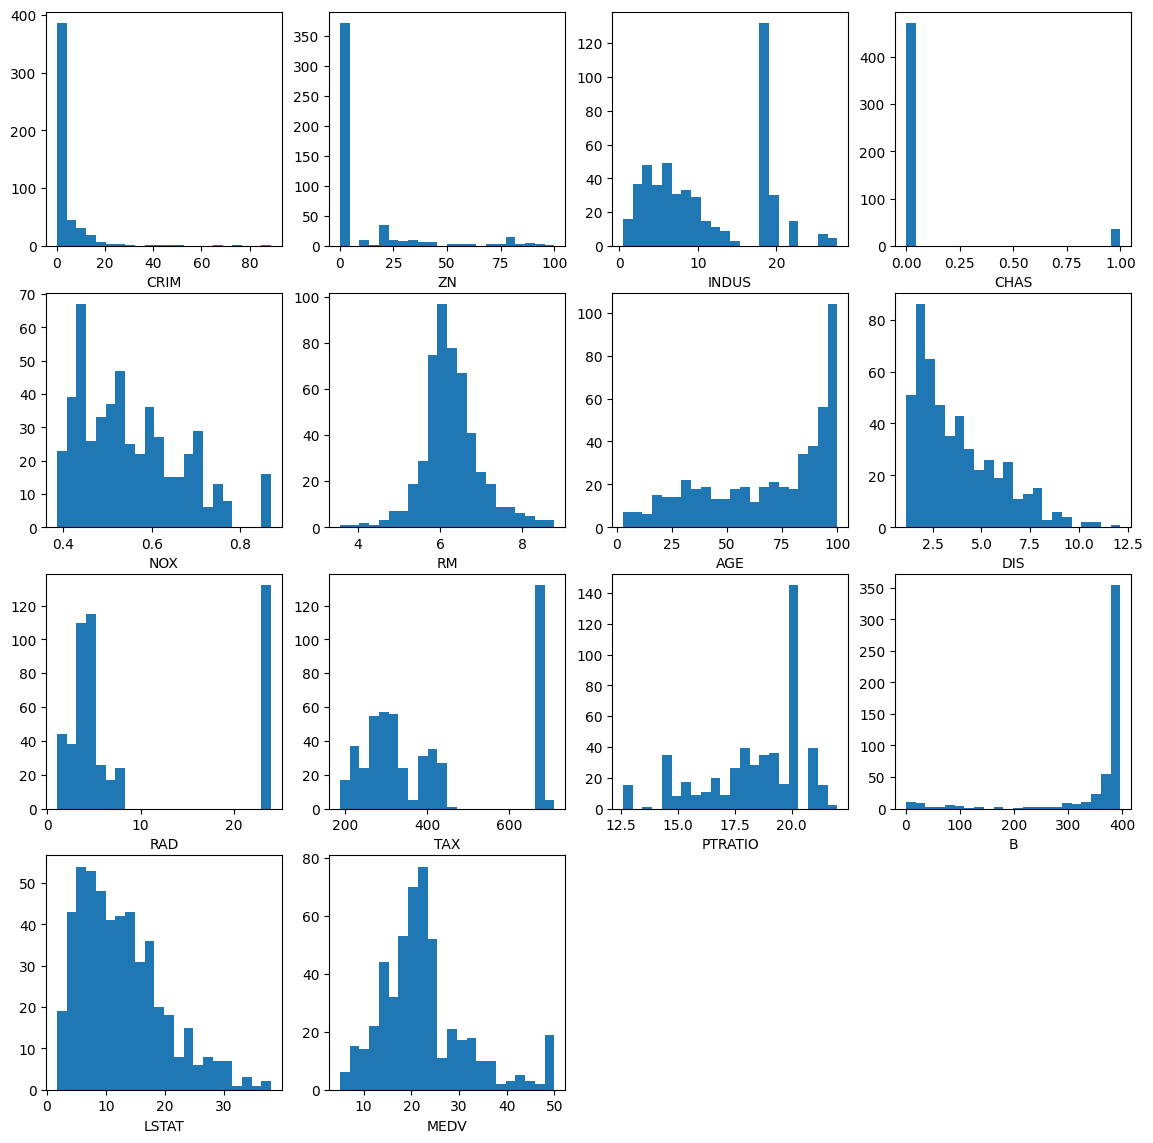

In [380]:
number_of_bins = round(np.sqrt(df.shape[0]))
print(f"Number of bins: {number_of_bins}")
plt.figure(figsize = (14, 14))
i = 1
for column in df.columns:
  plt.subplot(4, 4, i)
  plt.hist(df[column], bins = number_of_bins)
  plt.xlabel(column)
  i+=1
plt.show()

## regressor1 = model with all the features

In [381]:
def fit_regression_model_ols_and_get_test_r2(train_index, test_index, X, y):
  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  regressor = sm.OLS(y_train, X_train).fit()
  y_pred = regressor.predict(X_test)
  return regressor, calculate_test_r2(y_pred, y_test)

In [382]:
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
X = sm.add_constant(X)
test_r2 = []
number_of_folds = 10
random_state = 42
regressor1_models = []
spl = get_k_fold_cv(number_of_folds, random_state, X, y)
for i, (train_index, test_index) in enumerate(spl):
  print(f"Fold: {i}")
  model, test_r2_fold_i = fit_regression_model_ols_and_get_test_r2(train_index, test_index, X, y)
  test_r2.append(test_r2_fold_i)
  regressor1_models.append(model)
mean_test_r2 = np.mean(test_r2)
print(f"Mean test R-Squared from {number_of_folds} folds: {mean_test_r2}")

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Mean test R-Squared from 10 folds: 0.7170680714871458


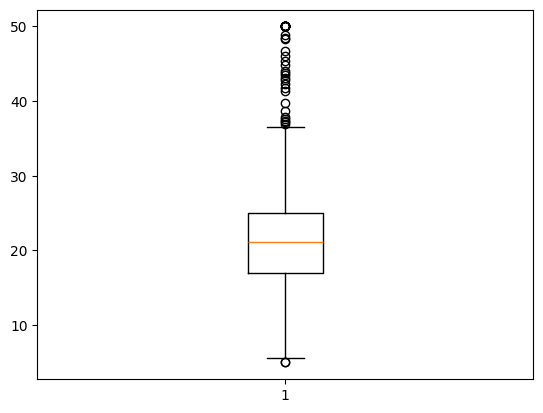

In [383]:
# Outliers detection using boxplot
boxplot = plt.boxplot(df['MEDV'])
plt.show()

In [384]:
outliers = [flier.get_ydata() for flier in boxplot["fliers"]][0]
print(f"Max outlier value: {max(outliers)}")
print(f"Min outlier value: {min(outliers)}")
print(f"Outlier values: {outliers}")
print(f"Number of outliers: {len(outliers)}")
print(f"Number of outliers whose value is 50: {len(outliers[outliers == 50.0])}")
outliers_indices = df[df['MEDV'].isin(outliers)].index
outliers_indices_50 = df[df['MEDV'].isin(outliers[outliers == 50.0])].index
print(f"Index of the outliers: {outliers_indices_50}")

Max outlier value: 50.0
Min outlier value: 5.0
Outlier values: [ 5.   5.  38.7 43.8 41.3 50.  50.  50.  50.  37.2 39.8 37.9 50.  37.
 50.  42.3 48.5 50.  44.8 50.  37.6 46.7 41.7 48.3 42.8 44.  50.  43.1
 48.8 50.  43.5 45.4 46.  50.  37.3 50.  50.  50.  50.  50. ]
Number of outliers: 40
Number of outliers whose value is 50: 16
Index of the outliers: Index([161, 162, 163, 166, 186, 195, 204, 225, 257, 267, 283, 368, 369, 370,
       371, 372],
      dtype='int64')


In [385]:
print(df.shape)
df2 = df.drop(index = outliers_indices_50)
print(df2.shape)
y2 = df2['MEDV']
X2 = df2.loc[:, df2.columns != 'MEDV']
X2 = sm.add_constant(X2)
print(y2.shape)
print(X2.shape)
regressor2_models = []
test_r2 = []

number_of_folds = 10
random_state = 42
spl = get_k_fold_cv(number_of_folds, random_state, X2, y2)

for i, (train_index, test_index) in enumerate(spl):
  print(f"Fold: {i}")
  model, test_r2_fold_i = fit_regression_model_ols_and_get_test_r2(train_index, test_index, X2, y2)
  test_r2.append(test_r2_fold_i)
  regressor2_models.append(model)
mean_test_r2 = np.mean(test_r2)
print(f"Mean test R-Squared from {number_of_folds} folds: {mean_test_r2}")

(506, 14)
(490, 14)
(490,)
(490, 14)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Mean test R-Squared from 10 folds: 0.748674393906269


In [386]:
# High Leverage points check using Leverage statistics (eg. Hat Matrix)
regressor4 = sm.OLS(y, X).fit()
influence = regressor4.get_influence()
leverage = influence.hat_matrix_diag
leverage_points = np.where(leverage > np.mean(leverage) + 2 * np.std(leverage))
print(leverage_points[0])
print(len(leverage_points[0]))

[152 155 214 353 364 365 367 380 405 410 414 418 488 489 490 491 492]
17


In [387]:
print(df.shape)
df3 = df.drop(leverage_points[0], axis = 0)
print(df3.shape)
y3 = df3['MEDV']
X3 = df3.loc[:, df3.columns != 'MEDV']
X3 = sm.add_constant(X3)
print(y3.shape)
print(X3.shape)

regressor4_models = []
test_r2 = []

number_of_folds = 10
random_state = 42
spl = get_k_fold_cv(number_of_folds, random_state, X3, y3)

for i, (train_index, test_index) in enumerate(spl):
  print(f"Fold: {i}")
  model, test_r2_fold_i = fit_regression_model_ols_and_get_test_r2(train_index, test_index, X3, y3)
  test_r2.append(test_r2_fold_i)
  regressor4_models.append(model)
mean_test_r2 = np.mean(test_r2)
print(f"Mean test R-Squared from {number_of_folds} folds: {mean_test_r2}")

(506, 14)
(489, 14)
(489,)
(489, 14)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Mean test R-Squared from 10 folds: 0.7224390772985739


In [388]:
number_of_folds = 10
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)

def forward_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  avg_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Data size: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
    result = forward_selection(X_train, y_train, X_test, y_test)
    all_fold_result.append(result)

  avg_r2_test = [0] * len(all_fold_result[0])
  for i in range(len(all_fold_result)):
    for k in range(len(all_fold_result[0])):
      avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

  for k in range(len(avg_r2_test)):
    avg_r2_test[k] = avg_r2_test[k]/number_of_folds
  print(avg_r2_test)

  return (all_fold_result, avg_r2_test)

all_fold_result, avg_r2_test = forward_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

*********** Fold: 0 ****************

Data size: (455, 13), (51, 13), (455,), (51,)
All Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
K = 0
current feature: CRIM
Training features: ['const', 'CRIM']
Best R-Squared and R-Squared-train after adding current feature: -inf, 0.15038051975827627
Current best feature: CRIM
current feature: ZN
Training features: ['const', 'ZN']
Best R-Squared and R-Squared-train after adding current feature: 0.15038051975827627, 0.10557636967432404
Current best feature: CRIM
current feature: INDUS
Training features: ['const', 'INDUS']
Best R-Squared and R-Squared-train after adding current feature: 0.15038051975827627, 0.22595292644430054
Current best feature: INDUS
current feature: CHAS
Training features: ['const', 'CHAS']
Best R-Squared and R-Squared-train after add

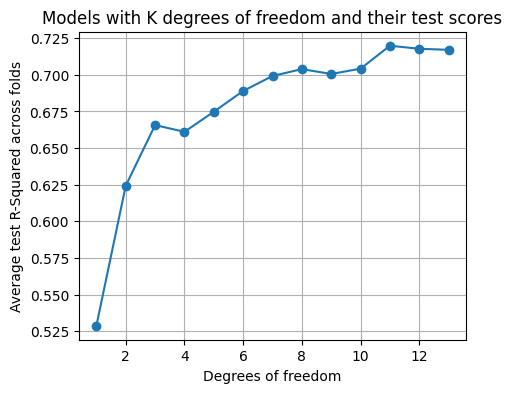

In [389]:
def plot_forward_selection_cv_result(avg_r2_test):
  plt.figure(figsize = (5, 4))
  plt.plot(range(1, len(avg_r2_test) + 1), avg_r2_test, marker = 'o')
  plt.xlabel('Degrees of freedom')
  plt.ylabel('Average test R-Squared across folds')
  plt.title('Models with K degrees of freedom and their test scores')
  plt.grid(True)
  plt.show()

plot_forward_selection_cv_result(avg_r2_test)

In [390]:
for i in range(len(all_fold_result)):
  print(all_fold_result[i][10][0].model.exog_names)
  print(all_fold_result[i][10][1])

['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS', 'RAD', 'CRIM', 'TAX', 'ZN']
0.7612243159124873
['const', 'LSTAT', 'RM', 'PTRATIO', 'B', 'DIS', 'NOX', 'CHAS', 'ZN', 'CRIM', 'RAD', 'TAX']
0.615485079742218
['const', 'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'DIS', 'NOX', 'ZN', 'B', 'RAD', 'CRIM', 'TAX']
0.7712651199391676
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'RAD', 'TAX', 'CRIM']
0.7163902072677897
['const', 'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'B', 'DIS', 'NOX', 'ZN', 'CRIM', 'RAD', 'TAX']
0.6163991916411921
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS', 'RAD', 'TAX', 'ZN', 'CRIM']
0.7980266926209139
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS', 'ZN', 'CRIM', 'RAD', 'TAX']
0.769227661354225
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'RAD', 'CRIM', 'TAX']
0.7959771074982461
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'RAD', 'TAX', 'CRIM']
0.746532900632636
['const', 'LS

In [391]:
sum_r2_test_11 = 0
avg_r2_test_11 = avg_r2_test[10]
for i in range(len(all_fold_result)):
  sum_r2_test_11 += ((all_fold_result[i][10][1] - avg_r2_test_11) ** 2)
variance_r2_test_11 = sum_r2_test_11 / (number_of_folds-1)
standard_error_r2_test_11 = ((variance_r2_test_11 / (number_of_folds)) ** (1/2))
interval = [avg_r2_test_11 - standard_error_r2_test_11, avg_r2_test_11]
print(avg_r2_test)
print(interval)

[0.5287118748747537, 0.6242921475839458, 0.6656886728027038, 0.6610795353481838, 0.6747954984450397, 0.6889860554944294, 0.6992152826715315, 0.7039003100233117, 0.700578499855307, 0.7042120154246619, 0.7198685765335143, 0.7177879176203311, 0.7170680714871447]
[0.6954887804611345, 0.7198685765335143]


Model of size 7 is the smallest sized model that has avg test r-squared of 0.6992152826715315 which falls under one-standard-error interval: [0.6954887804611345, 0.7198685765335143]

In [392]:
size_7_models = []
for i in range(len(all_fold_result)):
  print(all_fold_result[i][6][0].model.exog_names)
  model_i_features = all_fold_result[i][6][0].model.exog_names
  model_i_features.remove('const')
  size_7_models.append(model_i_features)
  print(all_fold_result[i][6][1])

print(size_7_models)

['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS']
0.7342535728066377
['const', 'LSTAT', 'RM', 'PTRATIO', 'B', 'DIS', 'NOX', 'CHAS']
0.5559597489999752
['const', 'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'DIS', 'NOX', 'ZN']
0.7170291189742986
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B']
0.7059282424761473
['const', 'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'B', 'DIS', 'NOX']
0.5976429721394798
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS']
0.7576778585745164
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS']
0.7572609243856905
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B']
0.813836449682303
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B']
0.7806129898475893
['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS']
0.5719509488286785
[['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS'], ['LSTAT', 'RM', 'PTRATIO', 'B', 'DIS', 'NOX', 'CHAS'], ['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'DIS', 'NOX', 'ZN'], ['LSTAT', 'RM

In [393]:
# validation set approach with 50 runs
number_of_runs = range(50)
final_size_7_model = ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS']
avg_test_r2_squared = 0
max_test_r2_squared = float('-inf')
min_test_r2_squared = float('inf')
for i in number_of_runs:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = None)
  X_train_subset = X_train.loc[:, final_size_7_model]
  X_train_subset = sm.add_constant(X_train_subset)
  model = sm.OLS(y_train, X_train_subset).fit()
  X_test_subset = X_test.loc[:, final_size_7_model]
  X_test_subset = sm.add_constant(X_test_subset)
  y_pred = model.predict(X_test_subset)
  test_r_squared = r2_score(y_test, y_pred)
  avg_test_r2_squared += test_r_squared/len(number_of_runs)
  if test_r_squared > max_test_r2_squared:
    max_test_r2_squared = test_r_squared
  if test_r_squared < min_test_r2_squared:
    min_test_r2_squared = test_r_squared

print(avg_test_r2_squared)
print([min_test_r2_squared, max_test_r2_squared])

0.7200989514113979
[0.5089116677645025, 0.8560092491581716]


In [394]:
# number_of_folds = 5
# random_state = 42
# y = df['MEDV']
# X = df.loc[: , df.columns != 'MEDV']
# print(X.columns)

# def backward_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state):
#   spl = get_k_fold_cv(number_of_folds, random_state, X, y)
#   all_fold_result = []
#   avg_fold_result = []
#   for i, (train_index, test_index) in enumerate(spl):
#     print(f"\n*********** Fold: {i} ****************\n")
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     print(f"Data size: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
#     result = backward_selection(X_train, y_train, X_test, y_test)
#     print(result)
#     all_fold_result.append(result)

#   avg_r2_test = [0] * len(all_fold_result[0])
#   for i in range(len(all_fold_result)):
#     for k in range(len(all_fold_result[0])):
#       avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

#   for k in range(len(avg_r2_test)):
#     avg_r2_test[k] = avg_r2_test[k]/number_of_folds
#   #print(avg_r2_test)

#   return (all_fold_result, avg_r2_test)

# all_fold_result_back, avg_r2_test_back = backward_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state)

In [395]:
# def plot_backward_selection_cv_result(avg_r2_test):
#   plt.figure(figsize = (5, 4))
#   plt.plot(range(1, len(avg_r2_test) + 1), avg_r2_test, marker = 'o')
#   plt.xlabel('Degrees of freedom')
#   plt.ylabel('Average test R-Squared across folds')
#   plt.title('Models with K degrees of freedom and their test scores')
#   plt.grid(True)
#   plt.show()

# plot_backward_selection_cv_result(avg_r2_test_back)

In [396]:
# print(avg_r2_test_back)
# for i in range(len(all_fold_result_back)):
#   print(all_fold_result_back[i][6][0].model.exog_names)
#   print(all_fold_result_back[i][6][1])

In [397]:
number_of_folds = 10
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)
def mixed_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  avg_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Data size: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
    model, r2_test = mixed_selection(X_train, y_train, X_test, y_test)
    all_fold_result.append([model, r2_test])
  return all_fold_result

all_fold_result_mixed = mixed_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state)

Streaming output truncated to the last 5000 lines.
current feature: NOX
Training features: ['const', 'LSTAT', 'RM', 'NOX']
Best R-Squared and R-Squared-train after adding current feature: 0.6527265659526312, 0.640036116239866
Current best feature: CHAS
current feature: AGE
Training features: ['const', 'LSTAT', 'RM', 'AGE']
Best R-Squared and R-Squared-train after adding current feature: 0.6527265659526312, 0.6399574017278563
Current best feature: CHAS
current feature: DIS
Training features: ['const', 'LSTAT', 'RM', 'DIS']
Best R-Squared and R-Squared-train after adding current feature: 0.6527265659526312, 0.6483202068613183
Current best feature: CHAS
current feature: RAD
Training features: ['const', 'LSTAT', 'RM', 'RAD']
Best R-Squared and R-Squared-train after adding current feature: 0.6527265659526312, 0.6431716445538473
Current best feature: CHAS
current feature: TAX
Training features: ['const', 'LSTAT', 'RM', 'TAX']
Best R-Squared and R-Squared-train after adding current feature: 0

In [398]:
all_features_across_folds = []
for i in range(number_of_folds):
    print(f"Fold: {i}, model size: {len(all_fold_result_mixed[i][0].model.exog_names)}, and model test R-Squared: {all_fold_result_mixed[i][1]}, model features: {all_fold_result_mixed[i][0].model.exog_names}")
    for feature in all_fold_result_mixed[i][0].model.exog_names:
      if feature != 'const':
        all_features_across_folds.append(feature)

print(len(all_features_across_folds))

Fold: 0, model size: 5, and model test R-Squared: 0.7799413140509356, model features: ['const', 'RM', 'PTRATIO', 'AGE', 'INDUS']
Fold: 1, model size: 9, and model test R-Squared: 0.71513669002254, model features: ['const', 'LSTAT', 'PTRATIO', 'DIS', 'NOX', 'ZN', 'RAD', 'TAX', 'AGE']
Fold: 2, model size: 8, and model test R-Squared: 0.8472390054210015, model features: ['const', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'INDUS', 'TAX']
Fold: 3, model size: 11, and model test R-Squared: 0.7112076732666401, model features: ['const', 'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'B', 'AGE', 'NOX', 'INDUS', 'CRIM', 'TAX']
Fold: 4, model size: 5, and model test R-Squared: 0.6300623340194763, model features: ['const', 'LSTAT', 'PTRATIO', 'CHAS', 'RAD']
Fold: 5, model size: 6, and model test R-Squared: 0.7758701049876593, model features: ['const', 'LSTAT', 'RM', 'CHAS', 'CRIM', 'AGE']
Fold: 6, model size: 11, and model test R-Squared: 0.7709200181165832, model features: ['const', 'LSTAT', 'RM', 'PTRATIO', 'DIS',

In [399]:
# counts of features across folds
feature_counts_across_folds = {}
for feature in all_features_across_folds:
  if feature in feature_counts_across_folds:
    feature_counts_across_folds[feature] += 1
  else:
    feature_counts_across_folds[feature] = 0
print(feature_counts_across_folds)

{'RM': 7, 'PTRATIO': 7, 'AGE': 6, 'INDUS': 2, 'LSTAT': 6, 'DIS': 2, 'NOX': 4, 'ZN': 1, 'RAD': 2, 'TAX': 3, 'B': 5, 'CHAS': 5, 'CRIM': 2}


In [400]:
# validation set approach with 50 runs for mixed selection
number_of_runs = range(50)
final_size_7_model = ['LSTAT', 'RM', 'PTRATIO', 'AGE', 'NOX', 'B', 'CHAS']
avg_test_r2_squared = 0
max_test_r2_squared = float('-inf')
min_test_r2_squared = float('inf')
for i in number_of_runs:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = None)
  X_train_subset = X_train.loc[:, final_size_7_model]
  X_train_subset = sm.add_constant(X_train_subset)
  model = sm.OLS(y_train, X_train_subset).fit()
  X_test_subset = X_test.loc[:, final_size_7_model]
  X_test_subset = sm.add_constant(X_test_subset)
  y_pred = model.predict(X_test_subset)
  test_r_squared = r2_score(y_test, y_pred)
  avg_test_r2_squared += test_r_squared/len(number_of_runs)
  if test_r_squared > max_test_r2_squared:
    max_test_r2_squared = test_r_squared
  if test_r_squared < min_test_r2_squared:
    min_test_r2_squared = test_r_squared

print(avg_test_r2_squared)
print([min_test_r2_squared, max_test_r2_squared])

0.6793240487261547
[0.5059075667501438, 0.8102095245743757]


In [401]:
# def plot_mixed_selection_cv_result(avg_r2_test_mixed):
#   plt.figure(figsize = (5, 4))
#   plt.plot(range(1, len(avg_r2_test_mixed) + 1), avg_r2_test_mixed, marker = 'o')
#   plt.xlabel('Degrees of freedom')
#   plt.ylabel('Average test R-Squared across folds')
#   plt.title('Models with K degrees of freedom and their test scores')
#   plt.grid(True)
#   plt.show()

# plot_mixed_selection_cv_result(avg_r2_test_mixed)

In [402]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

number_of_folds = 10
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)
alpha_values = range(1, 30)

def apply_ridge_regression(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    current_fold_result = []
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for i in alpha_values:
      ridge_model = Ridge(alpha=i)
      ridge_model.fit(X_train_scaled, y_train)
      y_pred = ridge_model.predict(X_test_scaled)
      r2_test = r2_score(y_test, y_pred)
      current_fold_result.append([i, r2_test])
    all_fold_result.append(current_fold_result)

  avg_r2_test = [0] * len(all_fold_result[0])
  for i in range(len(all_fold_result)):
    for k in range(len(all_fold_result[0])):
      avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

  for k in range(len(avg_r2_test)):
    avg_r2_test[k] = avg_r2_test[k]/number_of_folds

  return (all_fold_result, avg_r2_test)

all_fold_result_ridge, avg_r2_test_ridge = apply_ridge_regression(X, y, number_of_folds, random_state)
max_r2_test_ridge = max(avg_r2_test_ridge)
for i in range(len(avg_r2_test_ridge)):
  if avg_r2_test_ridge[i] == max_r2_test_ridge:
    print(f"Ridge alpha value for highest test R-squared: {i+1} with test R-squared: {max_r2_test_ridge}")

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

*********** Fold: 0 ****************


*********** Fold: 1 ****************


*********** Fold: 2 ****************


*********** Fold: 3 ****************


*********** Fold: 4 ****************


*********** Fold: 5 ****************


*********** Fold: 6 ****************


*********** Fold: 7 ****************


*********** Fold: 8 ****************


*********** Fold: 9 ****************

Ridge alpha value for highest test R-squared: 5 with test R-squared: 0.7173234290032489


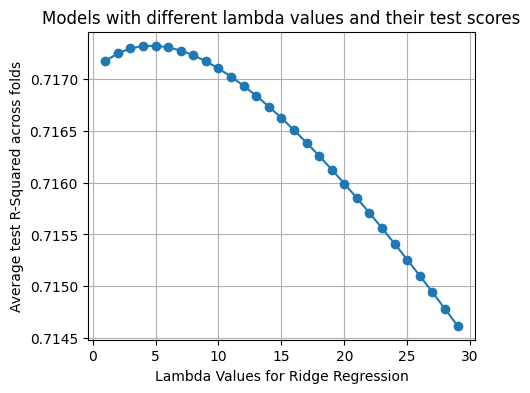

In [403]:
def ridge_regression_cv_result(avg_r2_test_ridge):
  plt.figure(figsize = (5, 4))
  plt.plot(alpha_values, avg_r2_test_ridge, marker = 'o')
  plt.xlabel('Lambda Values for Ridge Regression')
  plt.ylabel('Average test R-Squared across folds')
  plt.title('Models with different lambda values and their test scores')
  plt.grid(True)
  plt.show()

ridge_regression_cv_result(avg_r2_test_ridge)

In [404]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

number_of_folds = 10
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)
alpha_values = np.logspace(-4, -1, 10)

def apply_lasso_regression(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    current_fold_result = []
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for alpha_value in alpha_values:
      lasso_model = Lasso(alpha=alpha_value)
      lasso_model.fit(X_train_scaled, y_train)
      y_pred = lasso_model.predict(X_test_scaled)
      r2_test = r2_score(y_test, y_pred)
      current_fold_result.append([i, r2_test])
    all_fold_result.append(current_fold_result)

  avg_r2_test = [0] * len(all_fold_result[0])
  for i in range(len(all_fold_result)):
    for k in range(len(all_fold_result[0])):
      avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

  for k in range(len(avg_r2_test)):
    avg_r2_test[k] = avg_r2_test[k]/number_of_folds

  return (all_fold_result, avg_r2_test)

all_fold_result_lasso, avg_r2_test_lasso = apply_lasso_regression(X, y, number_of_folds, random_state)
max_r2_test_lasso = max(avg_r2_test_lasso)
for i in range(len(avg_r2_test_lasso)):
  if avg_r2_test_lasso[i] == max_r2_test_lasso:
    print(f"Lasso alpha value for highest test R-squared: {alpha_values[i]} with test R-squared: {max_r2_test_lasso}")

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

*********** Fold: 0 ****************


*********** Fold: 1 ****************


*********** Fold: 2 ****************


*********** Fold: 3 ****************


*********** Fold: 4 ****************


*********** Fold: 5 ****************


*********** Fold: 6 ****************


*********** Fold: 7 ****************


*********** Fold: 8 ****************


*********** Fold: 9 ****************

Lasso alpha value for highest test R-squared: 0.021544346900318822 with test R-squared: 0.7177259888428899


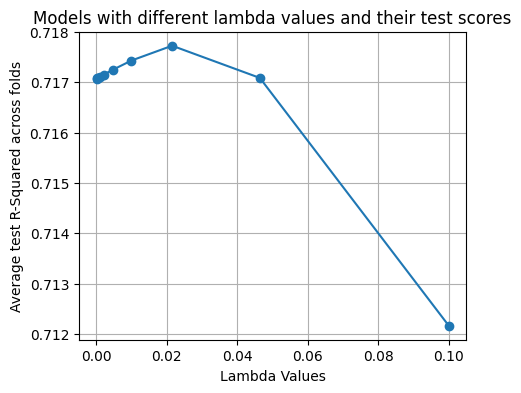

In [405]:
def lasso_regression_cv_result(avg_r2_test_lasso):
  plt.figure(figsize = (5, 4))
  plt.plot(alpha_values, avg_r2_test_lasso, marker = 'o')
  plt.xlabel('Lambda Values')
  plt.ylabel('Average test R-Squared across folds')
  plt.title('Models with different lambda values and their test scores')
  plt.grid(True)
  plt.show()

lasso_regression_cv_result(avg_r2_test_lasso)

In [406]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

number_of_folds = 5
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)
n_components = range(2, X.shape[1])

def apply_pca(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    current_fold_result = []
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for n_comp in n_components:
      print(f"Components: {n_comp}")
      pca = PCA(n_components = n_comp)
      X_train_pca = pca.fit_transform(X_train_scaled)
      print(f"Explained variance: {pca.explained_variance_ratio_}")
      model = LinearRegression()
      model.fit(X_train_pca, y_train)
      X_test_pca = pca.transform(X_test_scaled) # not fit_transform
      y_pred = model.predict(X_test_pca)
      r2_test = r2_score(y_test, y_pred)
      if r2_test < 0:
        print(f"y_test: {y_test[0:10]}")
        print(f"y_pred: {y_pred[0:10]}")
      print(f"R-squared Test: {r2_test}")
      current_fold_result.append([i, r2_test])
    all_fold_result.append(current_fold_result)

  avg_r2_test = [0] * len(all_fold_result[0])
  for i in range(len(all_fold_result)):
    for k in range(len(all_fold_result[0])):
      avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

  for k in range(len(avg_r2_test)):
    avg_r2_test[k] = avg_r2_test[k]/number_of_folds

  return (all_fold_result, avg_r2_test)

all_fold_result_pca, r2_test_pca = apply_pca(X, y, number_of_folds, random_state)
print(f"R-squared for PCA: {r2_test_pca}")
# max_r2_test_lasso = max(avg_r2_test_lasso)
# for i in range(len(avg_r2_test_lasso)):
#   if avg_r2_test_lasso[i] == max_r2_test_lasso:
#     print(f"Lasso alpha value for highest test R-squared: {i+1} with test R-squared: {max_r2_test_lasso}")

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

*********** Fold: 0 ****************

Components: 2
Explained variance: [0.46365886 0.11401877]
R-squared Test: 0.3899241117223178
Components: 3
Explained variance: [0.46365886 0.11401877 0.09775484]
R-squared Test: 0.6017288207486875
Components: 4
Explained variance: [0.46365886 0.11401877 0.09775484 0.06702416]
R-squared Test: 0.5959342867536124
Components: 5
Explained variance: [0.46365886 0.11401877 0.09775484 0.06702416 0.06538962]
R-squared Test: 0.5894152158374234
Components: 6
Explained variance: [0.46365886 0.11401877 0.09775484 0.06702416 0.06538962 0.05115833]
R-squared Test: 0.5958330596805669
Components: 7
Explained variance: [0.46365886 0.11401877 0.09775484 0.06702416 0.06538962 0.05115833
 0.04108269]
R-squared Test: 0.5952745874553012
Components: 8
Explained variance: [0.46365886 0.11401877 0.09775484 0.06702416 0.06538962 0.05115833
 0

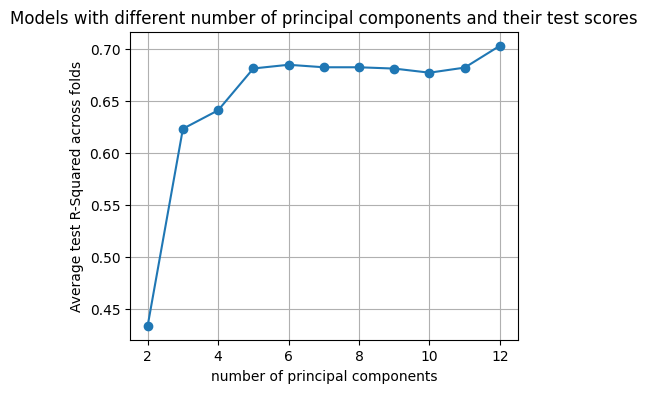

In [407]:
def pca_cv_result(n_components, avg_r2_test_pca):
  plt.figure(figsize = (5, 4))
  plt.plot(n_components, avg_r2_test_pca, marker = 'o')
  plt.xlabel('number of principal components')
  plt.ylabel('Average test R-Squared across folds')
  plt.title('Models with different number of principal components and their test scores')
  plt.grid(True)
  plt.show()

pca_cv_result(n_components, r2_test_pca)

### regressor1 (with all features) => test r-squared = 71.52%

## Detect Outliers, High Leverage Points and Influence

### Detect Outliers

In [408]:
# print(df.shape)
# df1 = df[~df['MEDV'].isin(outliers)]
# print(df1.shape)
# y1 = df1['MEDV']
# X1 = df1.loc[:, df1.columns != 'MEDV']
# print(y1.shape)
# print(X1.shape)
# X1 = sm.add_constant(X1)
# print(y1.shape)
# print(X1.shape)
# X1.head(2)
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = get_test_size(), random_state = get_random_state())
# regressor2 = sm.OLS(y1_train, X1_train).fit()
# print(regressor2.summary())
# y1_pred = regressor2.predict(X1_test)
# calculate_test_r2(y1_pred, y1_test)

### regressor2 (removing outliers detected by boxplot) => test r-squared = 74.43%, but 40 rows are removed

### regressor3 (removing outliers detected by Z-scores) => test r-squared = 71.61%, 3 rows are removed

### Check for high leverage points

### regressor5 (removing high-leverage-points detected by hat-matrix) => test r-squared = 73.12%, but 17 rows are removed

In [409]:
# # High Leverage check using Cook's distance
# cook_distance = regressor4.get_influence().cooks_distance[0]
# print(4 / df.shape[1])
# influential_observations = np.where(cook_distance > 4 / df.shape[1])
# print(influential_observations)

### Detecting High-leverage-points using Cook's distance resulted in no data

### Calculate Influence using DFFITS and DFBETAS

In [410]:
# # Influence calculation using DFFITS and DFBETAS
# dffits = regressor4.get_influence().dffits[0]
# dfbetas = regressor4.get_influence().dfbetas
# influential_dffits = np.where(np.abs(dffits) > 2 * np.sqrt(df.shape[1] * regressor4.df_model / regressor4.df_resid))
# coefficient_index = 0  # Index of the coefficient to analyze
# influential_dfbetas = np.where(np.abs(dfbetas[:, coefficient_index]) > 2 / np.sqrt(df.shape[1]))
# print(influential_dffits[0])
# print(influential_dfbetas[0])

In [411]:
# df4 = df.drop(influential_dffits[0], axis = 0)
# print(df4.shape)
# y4 = df4['MEDV']
# X4 = df4.loc[:, df4.columns != 'MEDV']
# X4 = sm.add_constant(X4)
# print(y4.shape)
# print(X4.shape)
# X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = get_test_size(), random_state = get_random_state())
# regressor6 = sm.OLS(y4_train, X4_train).fit()
# print(regressor6.summary())
# y4_pred = regressor6.predict(X4_test)
# calculate_test_r2(y4_pred, y4_test)

### regressor6 (removing influence-points detected by DFFITS) => test r-squared = 69.56%, 1 row is removed

In [412]:
# df5 = df.drop(influential_dfbetas[0], axis = 0)
# print(df5.shape)
# y5 = df5['MEDV']
# X5 = df5.loc[:, df5.columns != 'MEDV']
# X5 = sm.add_constant(X5)
# print(y5.shape)
# print(X5.shape)
# X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = get_test_size(), random_state = get_random_state())
# regressor7 = sm.OLS(y5_train, X5_train).fit()
# print(regressor7.summary())
# y5_pred = regressor7.predict(X5_test)
# calculate_test_r2(y5_pred, y5_test)

### regressor7 (removing influence-points detected by DFBETAS) => test r-squared = 74.56%, 3 rows are removed

## Checking Multicollinearity using VIF

In [413]:
import copy
print(X.columns)
vif_limit = 5.0
X_vif = copy.deepcopy(X)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

def remove_features_with_vif(X_vif, vif_data):
  dropped_features = []
  while(True and len(X_vif.columns) > 0):
    highest_vif_feature = vif_data[vif_data['VIF'] == max(vif_data['VIF'])]['feature']
    dropped_features.append(highest_vif_feature)
    X_vif = X_vif.drop(highest_vif_feature, axis = 1)
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]
    if vif_data[vif_data["VIF"] > vif_limit].shape[0] == 0:
      break
  print(vif_data)
  return X_vif.columns

selected_features = remove_features_with_vif(X_vif, vif_data)
print(f"Selected Features: {selected_features}")

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
    feature        VIF
0      CRIM   2.100373
1        ZN   2.844013
2     INDUS  14.485758
3      CHAS   1.152952
4       NOX  73.894947
5        RM  77.948283
6       AGE  21.386850
7       DIS  14.699652
8       RAD  15.167725
9       TAX  61.227274
10  PTRATIO  85.029547
11        B  20.104943
12    LSTAT  11.102025
  feature       VIF
0    CRIM  2.040522
1      ZN  2.237534
2    CHAS  1.059249
3     DIS  3.941629
4     RAD  3.738091
5   LSTAT  4.248513
Selected Features: Index(['CRIM', 'ZN', 'CHAS', 'DIS', 'RAD', 'LSTAT'], dtype='object')


In [414]:
y6 = df['MEDV']
X6 =df.loc[:, selected_features]
print(y6.shape)
print(X6.shape)
print(X6.columns)
X6 = sm.add_constant(X6)
print(X6.shape)
regressor8_models = []
test_r2 = []

number_of_folds = 10
random_state = 42
spl = get_k_fold_cv(number_of_folds, random_state, X6, y6)

for i, (train_index, test_index) in enumerate(spl):
  print(f"Fold: {i}")
  model, test_r2_fold_i = fit_regression_model_ols_and_get_test_r2(train_index, test_index, X6, y6)
  test_r2.append(test_r2_fold_i)
  regressor8_models.append(model)
mean_test_r2 = np.mean(test_r2)
print(f"Mean test R-Squared from {number_of_folds} folds: {mean_test_r2}")

(506,)
(506, 6)
Index(['CRIM', 'ZN', 'CHAS', 'DIS', 'RAD', 'LSTAT'], dtype='object')
(506, 7)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Mean test R-Squared from 10 folds: 0.5954728810535846


### 'PTRATIO', 'NOX', 'TAX', 'RM', 'B', 'AGE', 'INDUS' has VIF values much larger than 5. We will remove these features and rebuild our model

In [415]:
# y_fs = df['MEDV']
# X_fs = df.loc[: , df.columns != 'MEDV']
# print(y_fs.shape)
# print(X_fs.shape)
# X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs, y_fs, test_size = get_test_size(), random_state = get_random_state())
# forward_selection_results = forward_selection(X_fs_train, y_fs_train)
# print(forward_selection_results)

In [416]:
# y7 = df['MEDV']
# X7 = df.drop(columns = ['ZN', 'CRIM', 'RAD', 'TAX', 'AGE', 'INDUS'])
# print(y7.shape)
# print(X7.shape)
# X7 = sm.add_constant(X7)
# print(X7.shape)
# print(X7.head(2))
# X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size = get_test_size(), random_state = get_random_state())
# regressor9 = sm.OLS(y7_train, X7_train).fit()
# print(regressor9.summary())
# y7_pred = regressor9.predict(X7_test)
# calculate_test_r2(y7_pred, y7_test)

In [417]:
# y_bs = df['MEDV']
# X_bs = df.loc[: , df.columns != 'MEDV']
# print(y_bs.shape)
# print(X_bs.shape)
# X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_bs, y_bs, test_size = get_test_size(), random_state = get_random_state())
# backward_selection_results = backward_selection(X_bs_train, y_bs_train)
# print(backward_selection_results)